# Sheet 11

To run in Google Colab (highly recommended for exercise 3) go to: 
https://colab.research.google.com/drive/1kEEEyD_8uFzl97g7nzeEz5UEBKjpBD48?usp=sharing

## 1 Positional Encoding

In [1]:
%pylab inline
import torch
import torch.nn as nn
from tqdm.auto import tqdm

Populating the interactive namespace from numpy and matplotlib


$ E \in \mathbb{R}^{p\times n} $

$ E_{(2k), i} = \sin\left(2 i \cdot \exp\left(-\frac{k \cdot \log(10000)}{p}\right)\right) $

$ E_{(2k+1), i} = \cos\left(2 i \cdot \exp\left(-\frac{k \cdot \log(10000)}{p}\right)\right) $

In [ ]:
from IPython.display import Image

Image(filename = '1.(a).jpg')

In [99]:
p = 256
N = 64

E = np.zeros((p,N))


for k in range(int(p/2)):
    for i in range(0,N):
        exp = np.exp(-(k*np.log(10000))/p)
        E[2*k,i] = np.sin(2*i*exp)
        E[2*k+1,i] = np.cos(2*i*exp)

matrix = E.transpose()@E
plt.imshow(matrix)
plt.colorbar()

We see that each embedding dimension is highly correlated with itself(which should be obvious) , thats the reason why we get sharp line diagonally.As we move away from one dimension to other the covariance oscillates and 'die' exponentially. It means that a particular random feature is correlated to it's nearest features locally as we move away this correlation becomes zero.We have also plotted particular row to demonstrate this - 

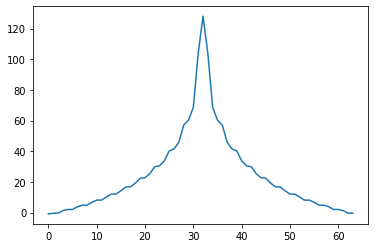

In [101]:
step =np.arange(0,64)
plt.figure()
plt.plot(step,matrix[32,:])
plt.show()

### 1.(C)

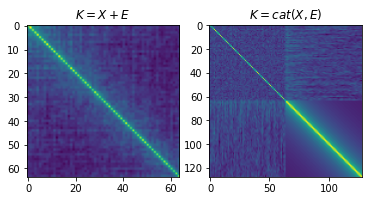

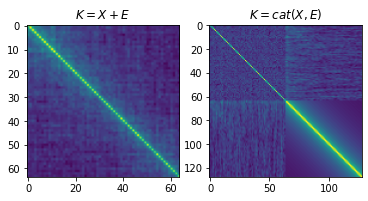

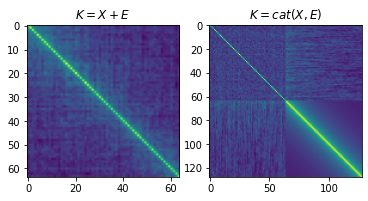

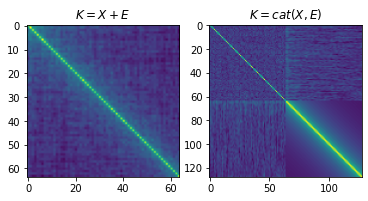

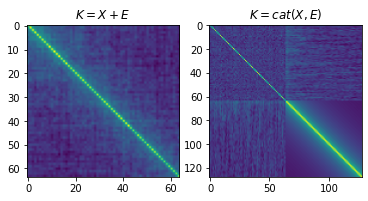

In [102]:
##first we need to calculate the variance of E along axis = 1 and take the average

var = np.mean(np.var(E,axis =1))
mean = np.mean(np.mean(E,axis = 1))
##now we will be generating (p X N) elements from a gaussian with different mus and sigma = sqrt(var)
mu = np.mean(mean)
sigma = np.sqrt(var)


for i in range(5):  ## we will plot the scores for 5 different random features which has same sigma and mus like E
    X = np.random.normal(mu,sigma,size = (p,N))
    K = X + E
    fig,ax = plt.subplots(nrows=1,ncols = 2)
    ax[0].imshow(K.transpose()@K)
    ax[0].set_title(r'$K = X+E$')

    K = np.hstack((X,E))
  
    ax[1].set_title(r'$K = cat(X,E)$')

    ax[1].imshow(K.transpose()@K)
    plt.show()




we see that for K = X+E, the scores are peaked at diagonally(same feature) and as we move away from diagonal(particular feature) covariance is distributed randomly.

For concatenated part the image is divided into three main parts -
The top left and top right part captures the covariance matrix of the feature and embedding space. Whereas, off diagonal part captures covariance between feature and embedding space.

We can also say that (X+E) part is just the summed version of all constituents part of cat(X,E)


## 3 Observing Oversmoothing

In [3]:
#@title Install Dependencies and get data from GitHub (will take a few minutes)
# install dependencies
!pip install -q condacolab
import condacolab
condacolab.install()
!conda install mamba -y
!mamba install -c rusty1s -c pytorch -c conda-forge -c lcerrone ctg-benchmark cpuonly torchmetrics=0.8.0 jupyter matplotlib

# get data from github
!git clone https://github.com/hci-unihd/mlph_sheet11/
!mv mlph_sheet11/ctg_data .

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:22
🔁 Restarting kernel...
Solving environment: / - \ | / - \ | / - \ | / - \ | / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - mamba


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2022.12.7  |       ha878542_0         143 KB  conda-forge
    certifi-2022.12.7          |     pyhd8ed1ab_0         147 KB  conda-forge
    colorama-0.4.6             |     pyhd8ed1ab_0          25 KB  conda-forge
    conda-22.11.1              |   py38h578d9bd_1         905 KB  conda-forge
    openssl-3.0.7              |       h0b41bf4_2         2.5 MB  conda-forge
    pluggy-1.0.0               |     pyhd8ed1ab

In [3]:
from ctg_benchmark.loaders.torch_loader import get_cross_validation_loaders, get_split_loaders
from ctg_benchmark.evaluation.metrics import NodeClassificationMetrics, aggregate_class
import torch
import numpy as np
from tqdm import trange
from tqdm.auto import tqdm
from torch_geometric.nn.models import GCN
from torch.optim import Adam
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [93]:
def validation(validation_loader, model):
    # set up evaluation
    eval_metrics = NodeClassificationMetrics(num_classes=9)

    accuracy_records, accuracy_class_records = [], []
   
    model.eval()
    # TODO: add calculation of mean feature std
    with torch.no_grad():
        val_loss  = 0
        std_batch = 0

        for val_batch in validation_loader:
            val_batch = val_batch.to(device)
            pred = model.forward(val_batch.x, val_batch.edge_index)
            logits = torch.log_softmax(pred, 1)
            pred = logits.max(1)[1]

            std_batch += torch.std(logits).item()

            V_loss_func = F.nll_loss(logits, val_batch.y)
            val_loss  += V_loss_func.item()
            # results is a dictionary containing a large number of classification metrics
            results = eval_metrics.compute_metrics(pred.cpu(), val_batch.y.cpu())
            acc = results['accuracy_micro']
            # aggregate class average the single class accuracy and ignores the embryo sack class (7)
            acc_class, _ = aggregate_class(results['accuracy_class'], index=7)

            accuracy_records.append(acc)
            accuracy_class_records.append(acc_class)

        val_loss /= len(validation_loader)

        stds = std_batch/len(validation_loader)


    return accuracy_records, accuracy_class_records,val_loss,stds


def simple_trainer(trainer_loader, validation_loader,num_layers=2):

    '''
    We modified this function such that it calls  upper validation function and returns both train loss 

    validation loss

    '''
    model = GCN(in_channels=74, hidden_channels=64, num_layers=num_layers, out_channels=9, dropout=0.5)
    model = model.to(device)
    optim = Adam(params=model.parameters(), lr=1e-2, weight_decay=1e-5)
    t_range = trange(25, desc=f'Epoch: {0: 03d}, training loss: {0/len(trainer_loader): .2f}')
    # basic training loop
    t_loss = []
    v_loss = []
    for epoch in t_range:
        loss_epoch = 0
        for batch in trainer_loader:
            optim.zero_grad()
            batch = batch.to(device)
            pred = model.forward(batch.x, batch.edge_index)
            logits = torch.log_softmax(pred, 1)
            loss = F.nll_loss(logits, batch.y)
            loss.backward()

            optim.step()
            loss_epoch += loss.item()
        

        t_range.set_description(f'Epoch: {epoch + 1: 03d}, training loss: {loss_epoch/len(trainer_loader): .2f}')
        t_range.refresh()
        t_loss.append(loss_epoch/len(trainer_loader))

        a_r,a_c_r,val_loss,stds = validation(validation_loader,model)
        v_loss.append(val_loss)

        ##once the training is done we pass our model to validation and c



    return model,t_loss,v_loss

#### Training GCN with 2 layers

Epoch:  25, training loss:  0.54: 100%|██████████| 25/25 [00:21<00:00,  1.15it/s]



GCN results for num_layers=2:
Accuracy 0.749 std: 0.041
Class Accuracy 0.652 std: 0.081


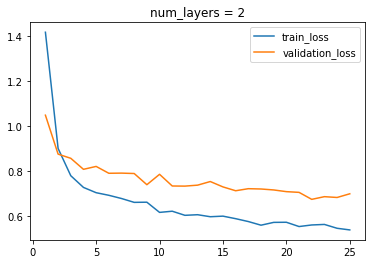

In [94]:
loaders = get_split_loaders(root='./ctg_data', batch_size=1, shuffle=True, grs=('label_grs_surface',))
training_loader, validation_loader = loaders['train'], loaders['val']

# example training for GCN with 1 layer
num_layers  = 2
model,t_loss,v_loss =  simple_trainer(training_loader, validation_loader, num_layers=num_layers)
accuracy_records, accuracy_class_records,val_loss,stds = validation(validation_loader, model)

# report results
print(f'\nGCN results for {num_layers=}:')
print(f'Accuracy {np.mean(accuracy_records):.3f} std: {np.std(accuracy_records):.3f}')
print(f'Class Accuracy {np.mean(accuracy_class_records):.3f} std: {np.std(accuracy_class_records):.3f}')


epoch = np.arange(1,26)
plt.plot(epoch,t_loss,label = "train_loss")
plt.plot(epoch,v_loss,label = "validation_loss")
plt.title("num_layers = "+str(num_layers))
plt.legend()
plt.show()

#### Repeating the same task for num_layers 1,5 and 20

Epoch:  25, training loss:  1.84: 100%|██████████| 25/25 [03:19<00:00,  7.98s/it]


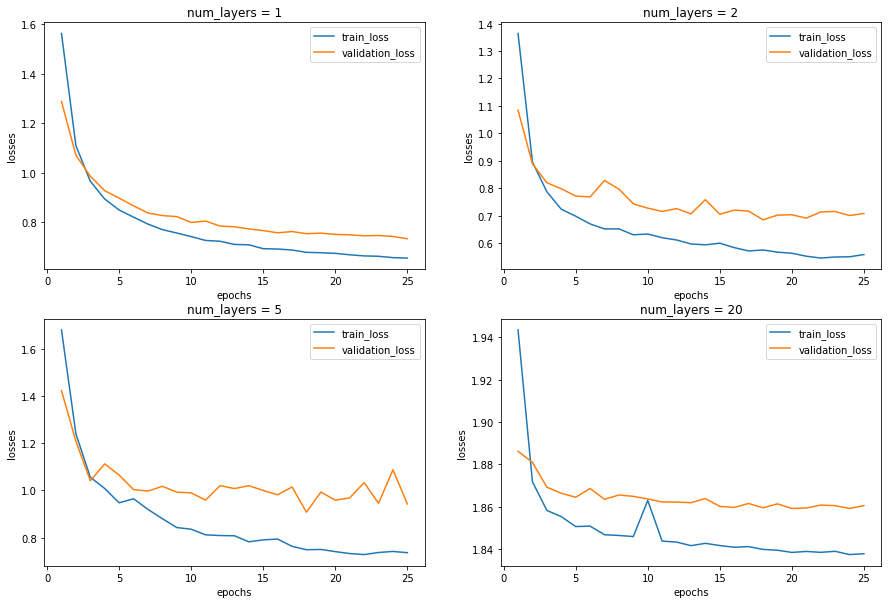

In [98]:
epoch = np.arange(1,26)

from matplotlib import pyplot as plt

num_layers_arr = [1,2,5,20]
fig,axs = plt.subplots(2,2,figsize = (15,10))
Models = [model] ##storing 

for num_layers,ax in zip(num_layers_arr,axs.flatten()):

    loaders = get_split_loaders(root='./ctg_data', batch_size=1, shuffle=True, grs=('label_grs_surface',))
    training_loader, validation_loader = loaders['train'], loaders['val']


    model,t_loss,v_loss =  simple_trainer(training_loader, validation_loader, num_layers=num_layers)
    ax.plot(epoch,t_loss,label = "train_loss")
    ax.plot(epoch,v_loss,label = "validation_loss")
    ax.set_title("num_layers = "+str(num_layers))
    ax.set_xlabel("epochs")
    ax.set_ylabel("losses")
    ax.legend()



    Models.append(model)
plt.show()




#### Computing standard deviations for each for the train models

In [103]:

for num_layers,model in zip(num_layers_arr,Models):
    A,B,V,std = validation(validation_loader,model)

    print(f'{num_layers = }, {std = }')

num_layers = 1, std = 11.968959728876749
num_layers = 2, std = 4.435128013292949
num_layers = 5, std = 11.36930227279663
num_layers = 20, std = 10.394613981246948


6.92244565486908

In [66]:
CC

[tensor(2.7386)]